## Imports

In [ ]:
import numpy as np

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from numpy.linalg import norm
from numpy.random import normal
from copy import copy
from scipy import stats

## Data

In [2]:
def generate_halfmoons(n_samples,noise,verbose=True):
    X , y = make_moons(n_samples,noise=noise)

    if verbose  : plt.scatter(X[:,0],X[:,1],c=y)
    
    return X , y

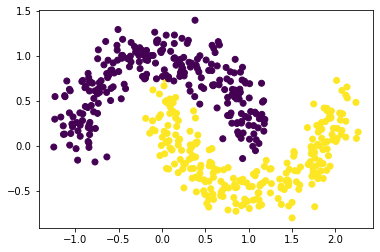

In [58]:
n_samples = 500
noise = 0.15
X , y = generate_halfmoons(n_samples,noise,verbose=True)

In [59]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7)

## Classifiers

In [19]:
rd_model = RandomForestClassifier(max_depth=5)
rd_model.fit(X_train,y_train)

knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_train,y_train)

svm_model = SVC(kernel='poly')
svm_model.fit(X_train,y_train)

SVC(kernel='poly')

## Generation of counterfactual examples

In [92]:
def uniform_in_sphere(x,n_samples,a_0,a_1):
    d = x.shape[0]
    # sample from gaussian distribution 
    samples = normal(0,1,(n_samples,d))
    
    # normalization
    samples_norm = samples / norm(samples,axis=1).reshape(-1,1)
    # sample from uniform distribution 
    u = np.random.uniform(a_0**d,a_1**d,1) ** (1/d)
    
    return x + samples_norm * u
    

def algorithme_gs_generation(model,sample,eta,n_samples):
    
    generated_samples_sph = uniform_in_sphere(sample,n_samples,0,eta)
    
    prediction_samples_sph = model.predict(generated_samples_sph)

    while np.where(prediction_samples_sph != model.predict(sample.reshape(1,2)),1,0).sum() != 0:
        
        eta = eta / 2
        
        generated_samples_sph = uniform_in_sphere(sample,n_samples,0,eta)
        
        prediction_samples_sph = model.predict(generated_samples_sph)
        
    a_0 = eta
    a_1 = 2*eta
    
    while np.where(prediction_samples_sph != model.predict(sample.reshape(1,2)),1,0).sum() == 0:
        
        generated_samples_sph = uniform_in_sphere(sample,n_samples,a_0,a_1)
        
        prediction_samples_sph = model.predict(generated_samples_sph)
        
        a_0 = a_1
        a_1 = a_1 + eta
        
    prediction_samples_sph = model.predict(generated_samples_sph)
    samples_diff_class = generated_samples_sph[np.where(prediction_samples_sph != model.predict(sample.reshape(1,2)))]
    
    enemy_ind = np.argmin(norm(np.array(samples_diff_class) - np.array(sample),axis=1))

    return samples_diff_class[enemy_ind]


def algorithme_gs_feature_selection(model,sample,enemy):
    
    enemy_prime = copy(enemy)

    while model.predict(sample.reshape(1,2)) != model.predict(enemy_prime.reshape(1,2)):

        enemy_star = copy(enemy_prime)
        
        # extraire uniquement les dimensions differentes
        indices_diffe_dim = np.where(enemy_prime != sample)[0]
        
        indi = indices_diffe_dim[np.argmin(enemy_prime[indices_diffe_dim] - sample[indices_diffe_dim])]

        enemy_prime[indi] = sample[indi]

    return enemy_star


def plot_decision_boundary(X, y, model,sample,contrf,title="Counterfactual"):
    # Crée une grille de points pour le tracé
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Prédire la classe pour chaque point de la grille
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Trace la frontière de décision et les points de données
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    
    if sample is not None:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.scatter(sample[0], sample[1], c='red', marker='o', s=50, label='Sample')
        plt.scatter(contrf[0], contrf[1], c='green', marker='X', s=50, label=title)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Grawing Sphere "+title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.legend()
    plt.show()
    
    
def relevance(model,sample,enemy_star,verbose=False):
    # we will define a new metric for the relevance based on four criteria
    # if one criteria is satisfied : 25%
    # if two criteria is satisfied : 50%
    # if three criteria is satisfied : 75%
    # if all(four) criteria is satisfied : 100%
    
    # threshold for proximity between sample and his counterfactual
    thresh = 0.8
        
    criteria_satf = 0
    va = False
    fea = False
    spar = False
    pro  = False
    
    
    # validity
    if model.predict(sample.reshape(1,2)) != model.predict(enemy_star.reshape(1,2)):
        va = True
        criteria_satf += 1
    
    # proximity
    if norm(sample - enemy_star) < thresh:
        pro = True
        criteria_satf += 1
        
    # sparseness 
    # if we keep at least one feature between the sample and his counterfactual 
    if np.where(sample == enemy_star,1,0).sum() != 0 :
        spar = True
        criteria_satf += 1
        
    # feasibility
    
    # Kolmogorov-Smirnov test
    statistic, p_value = stats.ks_2samp(X_train.ravel(), a.reshape(1,2).ravel())

    # Significance threshold
    alpha = 0.05

    if p_value >= alpha:
        # the counterfactual sample follows the same distribution as the data
        fea = True
        criteria_satf += 1

    
    if verbose:
        print(f"Validity {va} , Proximity {pro} , Sparseness {spar} , Feasibility {fea}")
    
    return int( (criteria_satf / 4)*100 )
    

## Visualisation

Sample  : 
[ 0.49759033 -0.27092134]


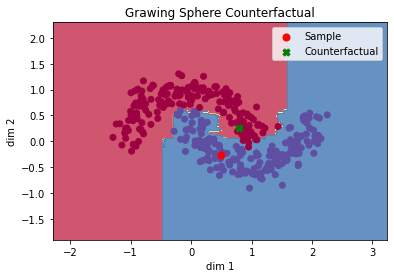

Counterfactual : 
[0.78926661 0.26015323]


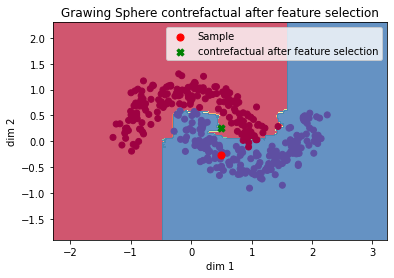

Counterfactual after feature selection
[0.49759033 0.26015323]


In [26]:
sample = X_train[0]
print("Sample  : ")
print(sample)

enemy = algorithme_gs_generation(rd_model,sample,eta=6,n_samples=10)
plot_decision_boundary(X_train, y_train, rd_model,sample,enemy)
print("Counterfactual : ")
print(enemy)

enemy_star = algorithme_gs_feature_selection(rd_model,sample,enemy)
plot_decision_boundary(X_train, y_train, rd_model,sample,enemy_star,"contrefactual after feature selection")
print("Counterfactual after feature selection")
print(enemy_star)

## Experimentations

#### 1- Study of the stability 
We are going to study the stability of the algorithm and its effect on random variances using two metrics: standard deviation and variance.

#### 2- Study relevance criteria  
We will determine what criteria or metrics we will use to assess the relevance of counterfactual examples.
This could include measures of : **validity , proximity , sparseness , feasibility .** 

#### 3- Define the factors to be studied
The factors we can study are : the stability of the algorithm with respect to its random component, the variation of the data to be explained, the choice of classifier, and the parameters of the Growing Spheres algorithm.

In [27]:
models  = [rd_model , knn_model , svm_model]
samples = [X_train[1] , X_train[13] , X_train[96] ]
eta_s = [ 5 , 10 , 15]

#### Study of the stability

In [103]:
# init
sample = samples[0]
enemies = []

liste_std = []
liste_var = []

for model,eta in zip(models,eta_s):

    for _ in range(10):

        # growing sphere - sphere generation 
        enemy = algorithme_gs_generation(model,sample,eta,n_samples=10)
        # growing sphere - features selection 
        enemy_star = algorithme_gs_feature_selection(model,sample,enemy)

        enemies.append(enemy_star)

    liste_std.append(np.std(enemies))
    liste_var.append(np.var(enemies))
      
print(liste_std)
print(f"The average standard deviation : {np.mean(liste_std)}")

print()

print(liste_var)
print(f"The average variance : {np.mean(liste_var)}")

[0.32114122546715024, 0.3348547455645037, 0.8843460761678601]
The average standard deviation : 0.5134473490665047

[0.10313168669454302, 0.11212770062706848, 0.7820679824334906]
The average variance : 0.3324424565850341


We can see following to results in the experimentations that : 
- The **variance** and the **standard deviation** are relatively close to **zero**.
- the results are coherent and not very sensitive to random variations, showing that the results are tightly clustered around a central value, which is a sign of **stability**.

In [101]:
# growing sphere - sphere generation 
enemy = algorithme_gs_generation(model,sample,eta,n_samples=10,seed=seed)
# growing sphere - features selection 
enemy_star = algorithme_gs_feature_selection(model,sample,enemy)

plot_decision_boundary(X_train, y_train, rd_model,sample,enemy_star,"contrefactual after feature selection")


rele = relevance(model,sample,enemy_star,True)

print(f"Relevance rate  : {rele}%")

TypeError: algorithme_gs_generation() got an unexpected keyword argument 'seed'

L'échantillon ne suit pas la même distribution que les données d'entraînement.
